In [1]:
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from rl.agent import *
from rl.utils import *
from rl.environment import *
from rl.criterion import *
import rl
import gym
from gym import wrappers
import math

GAMMA = 0.95

In [2]:
def build_model(state_size, action_size):
    model = Sequential()

    model.add(Linear(state_size, 10))
    model.add(Tanh())

    model.add(Linear(10, 2))
    model.add(SoftMax())
    return model


def create_agent(x):
    env = gym.make('CartPole-v1')
    env = GymEnvWrapper(env)
    return PPOAgent(env, 498)


def calc_baseline(r_rewards):
    max_steps = r_rewards.map(lambda x: x.shape[0]).max()
    pad = r_rewards.map(lambda x: np.pad(x, (0, max_steps-x.shape[0]), 'constant'))
    sum, count = pad.map(lambda x: (x, 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
    mean = sum / count
    return mean


def normalize(records, eps=1e-8):
    stats = records.map(lambda x: x[2]).stats()

    mean = stats.mean()
    std = stats.sampleStdev()

    return records.map(lambda x: (x[0], x[1], (x[2] - mean) / (std + eps), x[3]))

In [3]:
# from bigdl.util.common import JavaCreator
# JavaCreator.get_creator_class()
#JavaCreator.set_creator_class("com.intel.analytics.bigdl.python.api.PythonBigDLKeras")
JavaCreator.get_creator_class()
#JavaCreator.set_creator_class("com.intel.analytics.bigdl.rl.python.api.RLPythonBigDL")

['com.intel.analytics.bigdl.rl.python.api.RLPythonBigDL']

In [4]:
init_engine()
init_executor_gateway(sc)
redire_spark_logs()

In [5]:
node_num, core_num = get_node_and_core_number()
parallelism = node_num * core_num

In [6]:
criterion = PPOCriterion(0.1)
criterion = PGCriterion()
model = Linear(4, 5)

creating: createPPOCriterion
creating: createPGCriterion
creating: createLinear


In [7]:
# test environment on driver
env = gym.make('CartPole-v1')
env = wrappers.Monitor(env, "/tmp/cartpole-experiment", video_callable=lambda x: True, force=True)
env = GymEnvWrapper(env)
test_agent = PPOAgent(env, 1000)
state_size = env.gym.observation_space.shape[0]
action_size = env.gym.action_space.n

model = build_model(state_size, action_size)
criterion = PPOCriterion(0.1)

# create and cache several agents on each partition as specified by parallelism
# and cache it
with DistributedAgents(sc, create_agent=create_agent, parallelism=parallelism) as a:
    # a.agents is a RDD[Agent]
    agents = a.agents
    optimizer = None
    num_trajs_per_part = int(math.ceil(15.0 / parallelism))
    mean_std = []

    for i in range(120):
        with SampledTrajs(sc, agents, model, num_trajs_per_part=num_trajs_per_part) as trajs:
            # samples is a RDD[Trajectory]
            trajs = trajs.samples \
                .map(lambda traj: (traj.data["observations"],
                                   traj.data["actions"],
                                   traj.data["rewards"],
                                   traj.data["action_prob"]))

            rewards_stat = trajs.map(lambda traj: traj[2].sum()).stats()
            
            reward_mean = rewards_stat.mean()
            reward_std = rewards_stat.sampleStdev()
            reward_max = rewards_stat.max()
            mean_std.append([reward_mean, reward_std])

            print "*********** steps %s **************" % i
            print "reward mean:", reward_mean
            print "reward std:", reward_std
            print "reward max:", reward_max

            # calculate the discounted sum of future rewards
            trajs = trajs.map(lambda x: (x[0], x[1], discounted_sum_of_future_rewards(x[2], GAMMA), x[3]))

            # calculate advantages
            baseline = calc_baseline(trajs.map(lambda x: x[2]))
            trajs = trajs.map(lambda x: (x[0], x[1], x[2] - baseline[:len(x[2])], x[3]))

            # trajectories to records
            records = trajs.flatMap(lambda x: [(x[0][i], x[1][i], x[2][i], x[3][i]) for i in range(len(x[0]))])

            num_records = records.count()
            batch_size = 40

            print "total %s num_records" % num_records
            print "using %s batch_size" % batch_size

            # normalize advantages
            normalized = normalize(records)

            # to bigdl sample
            data = normalized.map(lambda x: obs_act_adv_old_prob_to_sample(x, 2))

            # update one step
            if optimizer is None:
                optimizer = Optimizer(model=model,
                                      training_rdd=data,
                                      criterion=criterion,
                                      optim_method=RMSprop(learningrate=0.005),
                                      end_trigger=MaxEpoch(2),
                                      batch_size=batch_size)
            else:
                optimizer.set_traindata(data, batch_size)
                optimizer.set_end_when(MaxEpoch(2*i + 2))

            model = optimizer.optimize()

            if (i + 1) % 10 == 0:
                import time

                start = time.time()
                step = test_agent.sample(model, num_trajs=1)[0].data["actions"].shape[0]
                end = time.time()
                print "************************************************************************"
                print "*****************sample video generated, %s steps**********************" % step
                print "************************************************************************"

env.gym.close()

INFO:gym.envs.registration:Making new env: CartPole-v1
[2018-03-15 11:15:03,445] Making new env: CartPole-v1
INFO:gym.wrappers.monitoring:Clearing 7 monitor files from previous run (because force=True was provided)
[2018-03-15 11:15:03,447] Clearing 7 monitor files from previous run (because force=True was provided)
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000000.mp4
[2018-03-15 11:15:03,449] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000000.mp4


creating: createSequential
creating: createLinear
creating: createTanh
creating: createLinear
creating: createSoftMax
creating: createPPOCriterion
*********** steps 0 **************
reward mean: 23.1875
reward std: 13.8285634347
reward max: 61.0
total 371 num_records
using 40 batch_size
creating: createRMSprop
creating: createMaxEpoch
creating: createDistriOptimizer
*********** steps 1 **************
reward mean: 24.25
reward std: 12.9331615109
reward max: 62.0
total 388 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 2 **************
reward mean: 23.625
reward std: 14.614490526
reward max: 64.0
total 378 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 3 **************
reward mean: 31.25
reward std: 18.6243568122
reward max: 79.0
total 500 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 4 **************
reward mean: 25.1875
reward std: 14.7205921529
reward max: 59.0
total 403 num_records
using 40 batch_siz

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000001.mp4
[2018-03-15 11:15:26,926] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000001.mp4



************************************************************************
*****************sample video generated, 49 steps**********************
************************************************************************
*********** steps 10 **************
reward mean: 60.625
reward std: 29.0445060783
reward max: 122.0
total 970 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 11 **************
reward mean: 62.375
reward std: 41.2987086158
reward max: 191.0
total 998 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 12 **************
reward mean: 89.0
reward std: 30.711561341
reward max: 150.0
total 1424 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 13 **************
reward mean: 105.6875
reward std: 39.3949552608
reward max: 179.0
total 1691 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 14 **************
reward mean: 126.6875
reward std: 49.705423916
reward max: 225.0
total 2027 

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000002.mp4
[2018-03-15 11:16:07,233] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000002.mp4



************************************************************************
*****************sample video generated, 122 steps**********************
************************************************************************
*********** steps 20 **************
reward mean: 205.625
reward std: 58.2945108908
reward max: 343.0
total 3290 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 21 **************
reward mean: 207.4375
reward std: 92.5317738221
reward max: 460.0
total 3319 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 22 **************
reward mean: 198.0
reward std: 45.4547393935
reward max: 301.0
total 3168 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 23 **************
reward mean: 188.75
reward std: 60.907032982
reward max: 339.0
total 3020 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 24 **************
reward mean: 170.0625
reward std: 28.6600040707
reward max: 220.0
total

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000003.mp4
[2018-03-15 11:16:59,611] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000003.mp4



************************************************************************
*****************sample video generated, 177 steps**********************
************************************************************************
*********** steps 30 **************
reward mean: 151.5
reward std: 23.5145345124
reward max: 185.0
total 2424 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 31 **************
reward mean: 161.375
reward std: 24.231866072
reward max: 200.0
total 2582 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 32 **************
reward mean: 161.0625
reward std: 45.7288657925
reward max: 324.0
total 2577 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 33 **************
reward mean: 185.0625
reward std: 24.5179356118
reward max: 234.0
total 2961 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 34 **************
reward mean: 169.5
reward std: 36.6987738215
reward max: 260.0
total 

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000004.mp4
[2018-03-15 11:17:50,385] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000004.mp4



************************************************************************
*****************sample video generated, 318 steps**********************
************************************************************************
*********** steps 40 **************
reward mean: 189.6875
reward std: 46.971933109
reward max: 313.0
total 3035 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 41 **************
reward mean: 174.375
reward std: 65.6758453822
reward max: 399.0
total 2790 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 42 **************
reward mean: 171.75
reward std: 22.4722050542
reward max: 222.0
total 2748 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 43 **************
reward mean: 164.25
reward std: 34.6188773167
reward max: 268.0
total 2628 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 44 **************
reward mean: 146.875
reward std: 21.1939456764
reward max: 200.0
total

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000005.mp4
[2018-03-15 11:18:36,660] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000005.mp4



************************************************************************
*****************sample video generated, 144 steps**********************
************************************************************************
*********** steps 50 **************
reward mean: 158.1875
reward std: 25.4852081281
reward max: 214.0
total 2531 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 51 **************
reward mean: 147.75
reward std: 20.1775452752
reward max: 178.0
total 2364 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 52 **************
reward mean: 148.125
reward std: 22.9691822522
reward max: 191.0
total 2370 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 53 **************
reward mean: 159.125
reward std: 18.2204098015
reward max: 183.0
total 2546 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 54 **************
reward mean: 148.5
reward std: 33.4464746523
reward max: 220.0
total

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000006.mp4
[2018-03-15 11:19:22,298] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000006.mp4



************************************************************************
*****************sample video generated, 116 steps**********************
************************************************************************
*********** steps 60 **************
reward mean: 195.1875
reward std: 49.7623937661
reward max: 310.0
total 3123 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 61 **************
reward mean: 241.375
reward std: 91.912186352
reward max: 498.0
total 3862 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 62 **************
reward mean: 246.375
reward std: 52.8947067295
reward max: 340.0
total 3942 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 63 **************
reward mean: 238.75
reward std: 91.5208537256
reward max: 463.0
total 3820 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 64 **************
reward mean: 258.9375
reward std: 99.0242184182
reward max: 433.0
tot

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000007.mp4
[2018-03-15 11:20:26,308] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000007.mp4



************************************************************************
*****************sample video generated, 229 steps**********************
************************************************************************
*********** steps 70 **************
reward mean: 235.0
reward std: 52.517933445
reward max: 369.0
total 3760 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 71 **************
reward mean: 240.25
reward std: 59.2503164549
reward max: 363.0
total 3844 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 72 **************
reward mean: 270.875
reward std: 92.4004870117
reward max: 478.0
total 4334 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 73 **************
reward mean: 283.0625
reward std: 101.508928179
reward max: 498.0
total 4529 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 74 **************
reward mean: 228.4375
reward std: 46.5402603488
reward max: 306.0
total

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000008.mp4
[2018-03-15 11:21:31,137] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000008.mp4



************************************************************************
*****************sample video generated, 205 steps**********************
************************************************************************
*********** steps 80 **************
reward mean: 265.5
reward std: 68.219254369
reward max: 428.0
total 4248 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 81 **************
reward mean: 217.875
reward std: 44.3905019871
reward max: 327.0
total 3486 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 82 **************
reward mean: 259.0625
reward std: 74.5032158143
reward max: 480.0
total 4145 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 83 **************
reward mean: 227.875
reward std: 93.2064911903
reward max: 498.0
total 3646 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 84 **************
reward mean: 232.5625
reward std: 65.7601386353
reward max: 360.0
tota

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000009.mp4
[2018-03-15 11:22:37,899] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000009.mp4



************************************************************************
*****************sample video generated, 300 steps**********************
************************************************************************
*********** steps 90 **************
reward mean: 239.4375
reward std: 69.2954724351
reward max: 356.0
total 3831 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 91 **************
reward mean: 247.375
reward std: 72.4678089453
reward max: 375.0
total 3958 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 92 **************
reward mean: 306.125
reward std: 102.159923649
reward max: 498.0
total 4898 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 93 **************
reward mean: 254.625
reward std: 48.5233620709
reward max: 318.0
total 4074 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 94 **************
reward mean: 316.5
reward std: 99.5757667976
reward max: 498.0
tota

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000010.mp4
[2018-03-15 11:23:46,935] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000010.mp4



************************************************************************
*****************sample video generated, 231 steps**********************
************************************************************************
*********** steps 100 **************
reward mean: 278.4375
reward std: 80.2753334884
reward max: 474.0
total 4455 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 101 **************
reward mean: 273.5625
reward std: 55.5433389346
reward max: 382.0
total 4377 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 102 **************
reward mean: 250.9375
reward std: 61.1320633274
reward max: 383.0
total 4015 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 103 **************
reward mean: 251.625
reward std: 76.8399852507
reward max: 498.0
total 4026 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 104 **************
reward mean: 282.4375
reward std: 80.0291353196
reward max: 

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000011.mp4
[2018-03-15 11:24:59,822] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000011.mp4



************************************************************************
*****************sample video generated, 417 steps**********************
************************************************************************
*********** steps 110 **************
reward mean: 277.8125
reward std: 81.633505172
reward max: 476.0
total 4445 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 111 **************
reward mean: 273.25
reward std: 91.6053128008
reward max: 498.0
total 4372 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 112 **************
reward mean: 272.8125
reward std: 111.651970426
reward max: 498.0
total 4365 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 113 **************
reward mean: 253.6875
reward std: 85.4164065037
reward max: 481.0
total 4059 num_records
using 40 batch_size
creating: createMaxEpoch
*********** steps 114 **************
reward mean: 215.5
reward std: 44.2312107001
reward max: 292.0

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000012.mp4
[2018-03-15 11:26:02,065] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.28810.video000012.mp4



************************************************************************

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/cartpole-experiment')
[2018-03-15 11:26:02,126] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/cartpole-experiment')



*****************sample video generated, 151 steps**********************
************************************************************************


(120, 2)


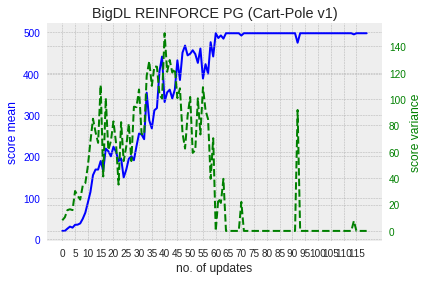

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
plt.style.use('bmh')
arr = np.asarray(mean_std)
print arr.shape
fig, ax1 = plt.subplots()
ind=np.arange(0,arr.shape[0],1)
#t = np.arange(0.01, 10.0, 0.01)
#s1 = np.exp(t)
ax1.plot(ind,arr[:,0], 'b-')
ax1.set_xlabel('no. of updates')
ax1.set_xticks(ind[::5])
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('score mean', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(ind,arr[:,1], 'g--')
ax2.set_ylabel('score variance', color='g')
ax2.tick_params('y', colors='g')
plt.grid(True)
#fig.tight_layout()
plt.title('BigDL REINFORCE PG (Cart-Pole v1)');